<a href="https://colab.research.google.com/github/shubhu1026/AI-ML/blob/main/Shubham%2CCalist_ADL_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/trainset.csv")
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,poutcome,nr.employed,Subscribed
0,41,blue-collar,divorced,basic.4y,yes,no,telephone,may,mon,1575,1,999,nonexistent,5191.0,yes
1,49,entrepreneur,married,university.degree,yes,no,telephone,may,mon,1042,1,999,nonexistent,5191.0,yes
2,49,technician,married,basic.9y,no,no,telephone,may,mon,1467,1,999,nonexistent,5191.0,yes
3,41,technician,married,professional.course,yes,no,telephone,may,mon,579,1,999,nonexistent,5191.0,yes
4,45,blue-collar,married,basic.9y,yes,no,telephone,may,mon,461,1,999,nonexistent,5191.0,yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29271 entries, 0 to 29270
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          29271 non-null  int64  
 1   job          29271 non-null  object 
 2   marital      29271 non-null  object 
 3   education    29271 non-null  object 
 4   housing      29271 non-null  object 
 5   loan         29271 non-null  object 
 6   contact      29271 non-null  object 
 7   month        29271 non-null  object 
 8   day_of_week  29271 non-null  object 
 9   duration     29271 non-null  int64  
 10  campaign     29271 non-null  int64  
 11  pdays        29271 non-null  int64  
 12  poutcome     29271 non-null  object 
 13  nr.employed  29271 non-null  float64
 14  Subscribed   29271 non-null  object 
dtypes: float64(1), int64(4), object(10)
memory usage: 3.3+ MB


In [ ]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
housing,0
loan,0
contact,0
month,0
day_of_week,0
duration,0


### Replacing Unknown Values as Nan and handling them

In [ ]:
import numpy as np

df.replace("unknown", np.nan, inplace=True)

In [ ]:
df.isnull().sum()

,0
age,0
job,260
marital,51
education,1227
housing,713
loan,713
contact,0
month,0
day_of_week,0
duration,0


### Plots

Text(0.5, 1.0, 'Target Variable Distribution')

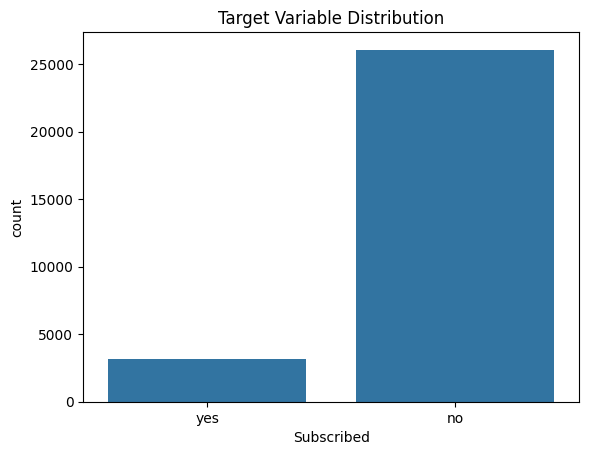

In [ ]:
import seaborn as sns

sns.countplot(x='Subscribed', data=df)
plt.title("Target Variable Distribution")

Text(0.5, 1.0, 'Age Distribution')

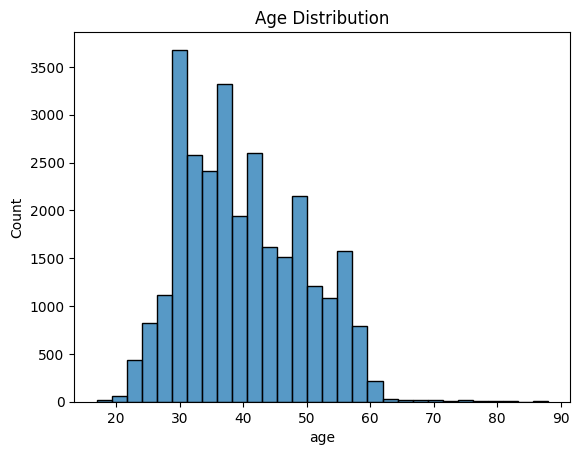

In [ ]:
sns.histplot(df['age'], bins=30)
plt.title("Age Distribution")

In [ ]:
X = df.drop(columns=['Subscribed'])
y = df['Subscribed']

In [ ]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

### Mapping yes and no to 1 and 0 respectively

In [ ]:
y = y.map({'no': 0, 'yes': 1})

In [ ]:
print(pd.Series(y).value_counts())

Subscribed
0    26075
1     3196
Name: count, dtype: int64


### Setting up the preprocessing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [ ]:
X = preprocessor.fit_transform(X)
if hasattr(X, "toarray"):
    X = X.toarray()

### Smote Over Sampling

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X, y = smote.fit_resample(X, y)

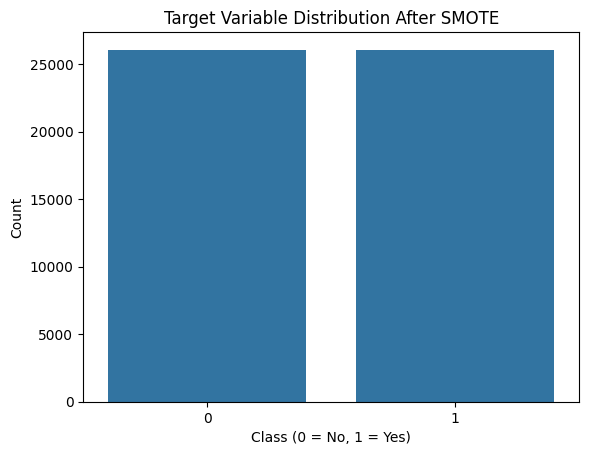

In [ ]:
sns.countplot(x=y)
plt.title("Target Variable Distribution After SMOTE")
plt.xlabel("Class (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [ ]:
print(pd.Series(y).value_counts())

Subscribed
1    26075
0    26075
Name: count, dtype: int64


### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

### X Train and X Validation shapes after split

In [ ]:
print("X_train:", X_train.shape, ", y_train:", y_train.shape)
print("X_val:", X_val.shape, ", y_val:", y_val.shape)

X_train: (41720, 50) , y_train: (41720,)
X_val: (10430, 50) , y_val: (10430,)


### Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Focal Loss

In [ ]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * K.pow(1. - p_t, gamma) * K.log(p_t)
        return K.mean(loss)
    return loss

In [ ]:
model.compile(optimizer='adam',
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

### Setting up Early Stopping and Reduce LR

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8751 - loss: 0.0188 - val_accuracy: 0.9468 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 2/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9424 - loss: 0.0098 - val_accuracy: 0.9488 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 3/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9450 - loss: 0.0091 - val_accuracy: 0.9504 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 4/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9499 - loss: 0.0086 - val_accuracy: 0.9522 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 5/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9517 - loss: 0.0084 - val_accuracy: 0.9532 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 6/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9520 - loss: 0.0081 - val_accuracy: 0.9542 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 7/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9507 - 

### Plotting Accuracy and Loss Curves

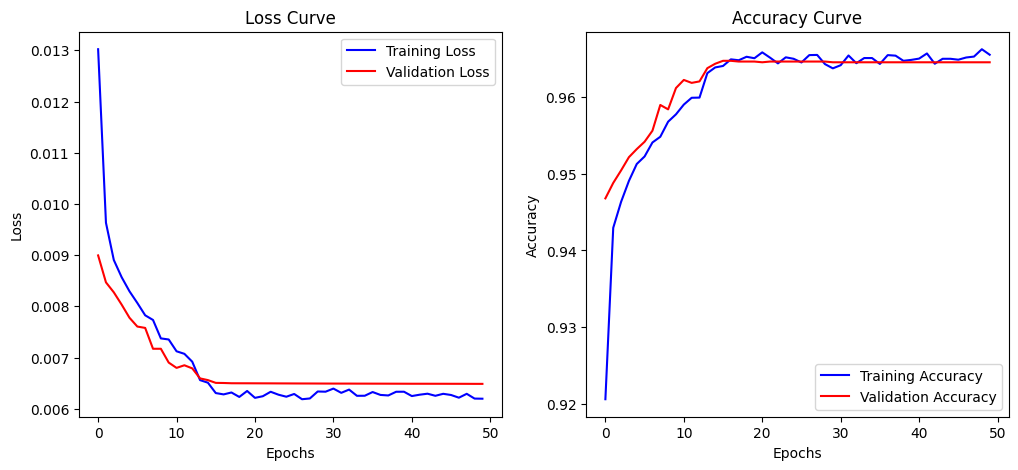

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc:.4f}")

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9628 - loss: 0.0066
Test Accuracy: 0.9645


In [ ]:
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      5176
           1       0.94      0.99      0.97      5254

    accuracy                           0.96     10430
   macro avg       0.97      0.96      0.96     10430
weighted avg       0.97      0.96      0.96     10430



### Confusion Matrix

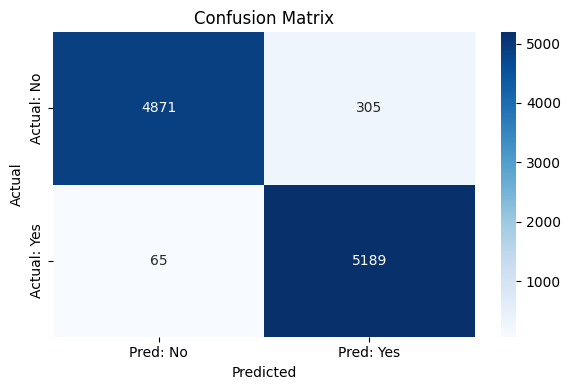

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Test Dataset

In [ ]:
df_test = pd.read_csv("/content/testset.csv")
df_test.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,poutcome,nr.employed,Subscribed
0,62,retired,married,university.degree,no,no,cellular,oct,fri,717,2,999,nonexistent,5017.5,yes
1,49,admin.,single,high.school,yes,no,cellular,oct,fri,136,2,999,nonexistent,5017.5,yes
2,36,admin.,married,university.degree,no,no,cellular,oct,fri,342,1,999,failure,5017.5,yes
3,70,retired,married,basic.4y,yes,no,cellular,oct,mon,131,1,999,nonexistent,5017.5,yes
4,60,retired,married,basic.4y,no,no,cellular,oct,mon,98,1,999,nonexistent,5017.5,yes


### Replacing Unknown with Nan in Test Dataset

In [ ]:
df_test.replace("unknown", np.nan, inplace=True)

In [ ]:
X_test = df_test.drop(columns=['Subscribed'])
y_test = df_test['Subscribed']

### Preprocessing on Test Dataset

In [ ]:
y_test = y_test.map({'no': 0, 'yes': 1})

In [ ]:
X_test = preprocessor.fit_transform(X_test)
if hasattr(X_test, "toarray"):
    X_test = X_test.toarray()

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8786 - loss: 0.0369
Test Accuracy: 0.8079


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

373/373 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


### Classificaiton Report

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     10473
           1       0.38      0.92      0.54      1444

    accuracy                           0.81     11917
   macro avg       0.68      0.86      0.71     11917
weighted avg       0.91      0.81      0.84     11917



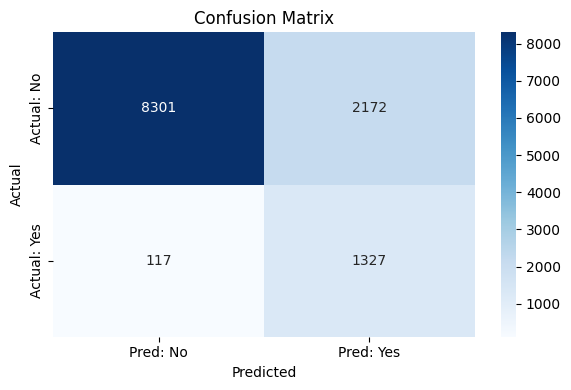

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()